In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import datetime as dt
import math
import numpy as np
from osgeo import gdal
import osr
import random
%matplotlib inline

import time



# define path to classification data
path = f'data/classification_data/'
path_comp = f'data/composites/'
path_coef = f'data/coefficients/'

# select arealstatistk
yearAS = 2004 # 2004 or 2013


""" //////////////////////// classes //////////////////////// """

# class to create a deep neural network (dnn). the dnn object is compatible with scikit-learn's
# classifier, i.e. also provides the fit and predict methods.
class DeepNeuralNetwork():
    
    def __init__(self):
        self.trained = False
        self.enc = OneHotEncoder(categories='auto')
        self.model = False
        
        # end of init method
    
    def fit(self, X_train, y_train):
        
        # one hot encoding data
        y_train_onehot = np.asarray(y_train)
        self.enc.fit(y_train_onehot.reshape(-1,1))
        y_train_onehot = self.enc.transform(y_train_onehot.reshape(-1,1)).todense()
        
        # getting input and output dimension of data
        input_dim = len(X_train.columns)
        output_dim = y_train_onehot.shape[1]
        
        # setting up model
        self.model = keras.Sequential([
            keras.layers.Dense(200, input_dim=input_dim, activation=tf.nn.tanh),
            keras.layers.Dense(100, activation=tf.nn.tanh),
            keras.layers.Dense(50, activation=tf.nn.tanh),
            keras.layers.Dense(output_dim, activation=tf.nn.softmax)
        ])
        opt = keras.optimizers.Adam(lr=0.001)
        self.model.compile(
          optimizer=opt,
          loss='categorical_crossentropy',
          metrics = ["accuracy"]
        )
        
        # training deep neural network
        batchsize = 48
        for i in range(6):
            self.model.fit(X_train, y_train_onehot, epochs=20, batch_size=batchsize, verbose=0)#, sample_weight=sample_weights.reshape(-1))
            batchsize *= 2
        
        self.trained = True
        # end of fit method
        

    def predict(self, X_test):
        
        if self.trained:
            y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        return y_pred
        # end of predict method

        

# class that provides methods to assess classification results by implementing various accuracy metrics.
class ErrorMatrix:

    
    def __init__(self,matrix,labels=False):
        
        self.matrix = matrix
        self.n_classes = matrix.shape[0]

        self.labels = labels if labels else list(range(self.n_classes))
        
        
    def column_total(self):
        
        return list(np.sum(self.matrix, axis=0))
        
    
    def row_total(self):
        
        return list(np.sum(self.matrix, axis=1))
    
    
    def total(self):
        
        return sum(self.column_total())
        
    
    def users_accuracies(self):
    
        row_total = self.row_total()
        uas = [self.matrix[i,i]/float(row_total[i])*100 for i in range(self.n_classes)]
    
        return uas

    
    def average_users_accuracy(self):
        
        return np.mean(self.users_accuracies())
    
    
    def producers_accuracies(self):
    
        column_total = self.column_total()
        pas = [self.matrix[i,i]/float(column_total[i])*100 for i in range(self.n_classes)]
    
        return pas
    
    
    def average_producers_accuracy(self):
        
        return np.mean(self.producers_accuracies())
    
    
    def overall_accuracy(self):
        
        correctly_classified = sum([self.matrix[i,i] for i in range(self.n_classes)])
        total = sum(list(np.sum(self.matrix, axis=1)))
        oa = correctly_classified/float(total)*100
        
        return oa
    
    
    def average_accuracy(self):
    
        aa = np.mean(self.users_accuracies())
    
        return aa

    
    def mean_accuracy(self):
    
        ma = (self.average_accuracy()+self.overall_accuracy())/2.
    
        return ma
    
    
    def kappa(self):
        
        # Cohen's kappa (Cohen, 1960; doi:10.1177/001316446002000104)
        X_test, y_pred = ([],[])
        for index, value in np.ndenumerate(self.matrix):
            pred, label = index
            X_test.extend([label for _ in range(value)])
            y_pred.extend([pred for _ in range(value)])
        
        return cohen_kappa_score(X_test,y_pred)
    
    
    def accuracy_metrics(self):
        
        metrics = {
            'OA': self.overall_accuracy(),
            'AvgUA': self.average_users_accuracy(),
            'AvgPA': self.average_producers_accuracy(),
            'AA': self.average_accuracy(),
            'MA': self.mean_accuracy(),
            'Kappa': self.kappa()
        }

        return metrics
        
        
    def print_matrix(self):
        
        print(self.matrix)
    
    
    def print_summary(self):
        
        print(f'Summary statistics (n Samples: {self.total()})')
        
        print()
        
        # overall statistics        
        print(f'{self.overall_accuracy():.2f} % (OA)')
        print(f'{self.average_users_accuracy():.2f} % (Average UA)')
        print(f'{self.average_producers_accuracy():.2f} % (Average PA)')
        print(f'{self.average_accuracy():.2f} % (AA = Average UA)')
        print(f'{self.mean_accuracy():.2f} % (MA = (OA + AA)/2)')        
        print(f'{self.kappa():.2f} (Kappa)')
        
        print()
        
        # class wise statistics
        column_total = self.column_total()
        row_total = self.row_total()
        
        uas = self.users_accuracies()
        pas = self.producers_accuracies()
        
        for i, label in enumerate(self.labels):
            print(f'{label}: {uas[i]:.2f} % (UA) n Class: {row_total[i]}; {pas[i]:.2f} % (PA) n Ref: {column_total[i]})')
            

    
    def to_latex(self):
        
        return ''

        

""" //////////////////////// functions //////////////////////// """


# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        year = 2006 if roi=='roi2' else 2007
    elif yearAS == 2013:
        year = 2015 if roi=='roi2' else 2016
    
    return year

# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function
    
    
def save_geotiff(data_cube,geotransform,epsg,fname):
    
    n_rows, n_cols = data_cube.shape[0:2]
    n_bands = data_cube.shape[2] if len(data_cube.shape)>2 else 1
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    if n_bands==1:
        ds.GetRasterBand(1).WriteArray(data_cube[:,:])
    else:
        for i_band in range(n_bands):
            ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save function
    
    
    # function to plot a classified image  
def plot(image_classified):
     
    # define class labels and colors
    classes = [
        'Artificial areas',
        'Grass and herb vegetation',
        'Brush vegetation', 'Tree vegetation',
        'Bare land', 'Water',
        'Glacier, perpetual snow'
    ]
    
    hex_colors = [
        "#FF0000",
        "#FFFF00",
        "#B2B200",
        "#00B200",
        "#804D33",
        '#0000FF',
        '#B2B2B2'
    ]
    
    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
        
    # plot map
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(image_classified, cmap=cmap, norm=norm)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
    cbar.ax.set_yticklabels(classes)
    plt.show()
    # end of plot function
    
      

def train_validate_classifier(clf, train, test, features, label):
        
    # getting training and testing features
    X_train = train[features]
    X_test = test[features]
    
    # getting training and testing labels
    y_train = train[label]
    y_test = test[label]
    
    # training classifier
    start_time = time.time()
    clf.fit(X_train,y_train)
    run_time = time.time() - start_time
    
    # creating error matrix for validation
    y_pred = clf.predict(X_test)
    error_matrix = confusion_matrix(y_test, y_pred)
    
    return ErrorMatrix(error_matrix), run_time, clf



def apply_gaussian_kernel(data_kernel,gaussian_kernel):
    
    assert(data_kernel.shape==gaussian_kernel.shape)
    
    class_probabilities = {}
    for index, prob in np.ndenumerate(gaussian_kernel):
        class_ = int(data_kernel[index[0],index[1]])
        class_prob = class_probabilities.get(class_,0)
        class_probabilities[class_] = class_prob + prob
    
    new_class = max(class_probabilities, key=class_probabilities.get)
    return new_class




def gaussian_filter(image,kernel_size):
    
    kernel5 = np.array([
        [1,4,7,4,1],
        [4,16,26,16,4],
        [7,26,41,26,7],
        [4,16,26,16,4],
        [1,4,7,4,1]
    ])

    kernel3 = np.array([
        [1,2,1],
        [2,4,2],
        [1,2,1]
    ])
    
    gaussian_kernel = kernel3 if kernel_size==3 else kernel5 
    offset = gaussian_kernel.shape[0]//2

    filtered_image = np.copy(image)
    padded_image = np.pad(image, pad_width=((offset,offset),(offset,offset),(0,0)), mode='edge')
    
    # loop over all pixels ignoring edges
    for i in range(offset,padded_image.shape[0]-offset):
        for j in range(offset,padded_image.shape[1]-offset):
        
            data_kernel = padded_image[i-offset:i+offset+1,j-offset:j+offset+1,0]
            class_filtered = apply_gaussian_kernel(data_kernel,gaussian_kernel)
            filtered_image[i-offset,j-offset,0] = class_filtered
            
    return filtered_image


def validate_filtered(trained_clf,spatial,test,feature_image,label):
    
    y_test, y_pred = ([],[])
    
    for roi in rois:
        
        # subsetting test data to roi
        test_roi = test[test['roi']==roi]
        x_coords = list(test_roi['X'])
        y_coords = list(test_roi['Y'])
        labels = list(test_roi[label])
        
        # getting image data for roi
        year = 2006 if roi=='roi2' else 2007
        image, geotransform, epsg = geotiff_to_datacube(f'{feature_image}_{roi}_{year}.tif')
        xOrigin = geotransform[0]
        yOrigin = geotransform[3]
        pixelWidth = geotransform[1]
        pixelHeight = -geotransform[5]
        
        for i, (x_coord,y_coord,class_) in enumerate(zip(x_coords,y_coords,labels)):
            
            # computing column and row indices
            icol = int((x_coord - xOrigin) / pixelWidth)
            irow = int((yOrigin - y_coord ) / pixelHeight)

            if not spatial:
                
                # create vector of pixels for classifier input
                kernel = image[irow-1:irow+2,icol-1:icol+2,:]
                feature_vector = kernel.reshape((3*3, kernel.shape[2]))
            
            else:
                
                # create vector of kernels for classifier input
                feature_vector = []
                for irowk in range(irow-1,irow+2):
                    for icolk in range(icol-1,icol+2):
                        kernel = image[irowk-1:irowk+2,icolk-1:icolk+2,:]
                        kernel_flattened = kernel.flatten()
                        feature_vector.append(kernel_flattened)
                feature_vector = np.array(feature_vector)
                if i ==0: print(feature_vector.shape)
                                            
            # classify pixel vector and reshape to image
            predictions = trained_clf.predict(feature_vector)
                
            classified_kernel = predictions.reshape((3,3))
        
            class_pred = apply_gaussian_kernel(classified_kernel,gaussian_kernel3)
            
            y_test.append(class_)
            y_pred.append(class_pred)
                
    
    error_matrix = confusion_matrix(y_test, y_pred)
    
    # computing average user's and producer's accuracy
    avg_uacc = compute_avg_uacc(error_matrix)
    avg_pacc = compute_avg_pacc(error_matrix)
    
    return (avg_uacc, avg_pacc)




In [2]:
data_coefs = pd.read_csv(f'{path}coefficients_labeled_as{yearAS}.csv')
data_coefs.head()

,roi,X,Y,land_cover,topleft_blue_c,topleft_blue_a1,topleft_blue_b1,topleft_green_c,topleft_green_a1,topleft_green_b1,...,lowerright_red_b1,lowerright_nir_c,lowerright_nir_a1,lowerright_nir_b1,lowerright_swir1_c,lowerright_swir1_a1,lowerright_swir1_b1,lowerright_swir2_c,lowerright_swir2_a1,lowerright_swir2_b1
0,roi1,667600,252600,2,325.552948,55.630993,32.489609,515.907349,-14.854885,89.555176,...,64.624893,2389.831055,-1125.281372,-215.238480,1259.682617,-328.539520,-0.342632,640.255493,-79.420906,60.188084
1,roi1,667700,252600,3,284.919769,27.789513,50.642258,445.790924,-38.991756,82.616188,...,58.341286,2131.451660,-1270.859253,-47.280304,1117.687988,-469.864166,73.703926,588.587219,-159.614395,82.927773
2,roi1,667800,252600,3,262.668854,17.658516,26.511618,416.402771,-51.110100,51.083614,...,64.631248,1809.830200,-503.234863,18.854675,843.746643,-249.886932,54.688435,432.331055,-117.106590,44.694645
3,roi1,667900,252600,3,248.608994,1.748695,19.447910,399.852753,-56.740559,45.920238,...,81.518433,1844.627808,-428.580078,57.452545,821.924438,-237.290436,112.084305,427.219788,-125.443512,76.133369
4,roi1,668000,252600,3,258.873657,-7.505610,21.662420,426.105316,-74.219902,44.687603,...,61.442841,1752.874146,-645.925171,102.277191,916.252747,-267.664307,150.652328,484.190948,-123.407143,95.016434


In [3]:
data_acomp = pd.read_csv(f'{path}annual_composite_labeled_as{yearAS}.csv')
data_acomp.head()

,roi,X,Y,land_cover,blue,green,red,nir,swir1,swir2
0,roi1,667600,252600,2,212.0,304.0,208.0,979.0,751.0,361.0
1,roi1,667700,252600,3,208.0,325.0,213.0,1392.0,850.0,465.0
2,roi1,667800,252600,3,205.0,215.0,196.0,970.0,312.0,153.0
3,roi1,667900,252600,3,203.0,321.0,193.0,1329.0,445.0,216.0
4,roi1,668000,252600,3,212.0,309.0,218.0,1224.0,588.0,312.0


In [4]:
data_scomp = pd.read_csv(f'{path}seasonal_composite_labeled_as{yearAS}.csv')
data_scomp.head()

,roi,X,Y,land_cover,blue_spring,blue_summer,blue_autumn,green_spring,green_summer,green_autumn,...,red_autumn,nir_spring,nir_summer,nir_autumn,swir1_spring,swir1_summer,swir1_autumn,swir2_spring,swir2_summer,swir2_autumn
0,roi1,667600,252600,2,206.0,199.0,198.0,301.0,304.0,276.0,...,210.0,979.0,979.0,874.0,645.0,645.0,629.0,361.0,361.0,339.0
1,roi1,667700,252600,3,215.0,208.0,202.0,324.0,325.0,321.0,...,221.0,1223.0,1223.0,1243.0,850.0,850.0,850.0,473.0,469.0,467.0
2,roi1,667800,252600,3,187.0,182.0,182.0,218.0,215.0,202.0,...,127.0,970.0,970.0,934.0,311.0,310.0,304.0,153.0,153.0,149.0
3,roi1,667900,252600,3,183.0,203.0,173.0,322.0,321.0,252.0,...,165.0,1329.0,1329.0,1286.0,451.0,451.0,448.0,214.0,207.0,169.0
4,roi1,668000,252600,3,207.0,212.0,176.0,261.0,217.0,239.0,...,216.0,1224.0,1224.0,1198.0,588.0,588.0,585.0,317.0,317.0,280.0


In [ ]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
seasons = ['spring','summer','autumn']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
classifiers['dnn'] = DeepNeuralNetwork()



# data container and function to add data to it
data = []


# define number of iterations
n_iterations = 30

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    # splitting data (using a different split for each iteration)
    train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
    # train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
    train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        
    for clf_key in classifiers.keys():
        print(clf_key,end=' ')
        
        clf  = classifiers[clf_key]
        
        # ac (annual composite)
        error_matrix_ac, run_time_ac, _ = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
        ametrics_ac = error_matrix_ac.accuracy_metrics()
        data.append((clf_key,'ac',test_size,run_time_ac,ametrics_ac))
        
        # sc (seasonal composite)
        # error_matrix_sc, run_time_sc, _ = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
        # ametrics_sc = ErrorMatrix(error_matrix_sc).accuracy_metrics()
        # data.append((clf_key,'sc',test_size,run_time_sc,ametrics_sc))
        
        # t (time series)
        error_matrix_t, run_time_t, _ = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
        ametrics_t = error_matrix_t.accuracy_metrics()
        data.append((clf_key,'t',test_size,run_time_t,ametrics_t))
        
        # ts (time series-spatial)
        error_matrix_ts, run_time_ts, _ = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
        ametrics_ts = error_matrix_ts.accuracy_metrics()
        data.append((clf_key,'ts',test_size,run_time_ts,ametrics_ts))
        
    print('')
    
d = {
    'classifier': [entry[0] for entry in data],
    'method': [entry[1] for entry in data],
    'testsize': [f'{entry[2]:.2f}' for entry in data],
    'runtime': [entry[3] for entry in data],
    'OA': [entry[4]['OA'] for entry in data],
    'AvgUA': [entry[4]['AvgUA'] for entry in data],
    'AvgPA': [entry[4]['AvgPA'] for entry in data],
    'AA': [entry[4]['AA'] for entry in data],
    'MA': [entry[4]['MA'] for entry in data],
    'Kappa': [entry[4]['Kappa'] for entry in data],
}
df = pd.DataFrame(data=d)
df.to_csv(f'{path}classifier_comparison_as{yearAS}.csv', encoding='utf-8', index=False)
df.head()

Iteration: 1/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 2/30
rf svm dnn 
Iteration: 3/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 4/30
rf svm dnn 
Iteration: 5/30
rf svm dnn 
Iteration: 6/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 7/30
rf svm dnn 
Iteration: 8/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 9/30
rf svm dnn 
Iteration: 10/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 11/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 12/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 13/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 14/30
rf svm dnn 
Iteration: 15/30
rf svm dnn 
Iteration: 16/30
rf svm dnn 
Iteration: 17/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 18/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 19/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 20/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 21/30
rf svm dnn 
Iteration: 22/30
rf svm dnn 
Iteration: 23/30
rf svm dnn 

/home/shafner/anaconda3/envs/masterthesis/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide



Iteration: 24/30
rf svm dnn 
Iteration: 25/30
rf svm dnn 
Iteration: 26/30
rf svm dnn 

                   testsize     runtime         OA      AvgUA      AvgPa  \
method classifier                                                          
ac     rf               0.3   18.116459  75.490499  70.393265  76.945795   
sc     rf               0.3   33.722374  76.182287  71.230056  78.963810   
t      rf               0.3   46.012827  78.460548  73.065749  78.883737   
ts     rf               0.3  157.816480  79.643800  73.289162  81.554697   

                          AA         MA     Kappa  
method classifier                                  
ac     rf          70.393265  72.941882  0.682099  
sc     rf          71.230056  73.706172  0.690855  
t      rf          73.065749  75.763148  0.720967  
ts     rf          73.289162  76.466481  0.735297  


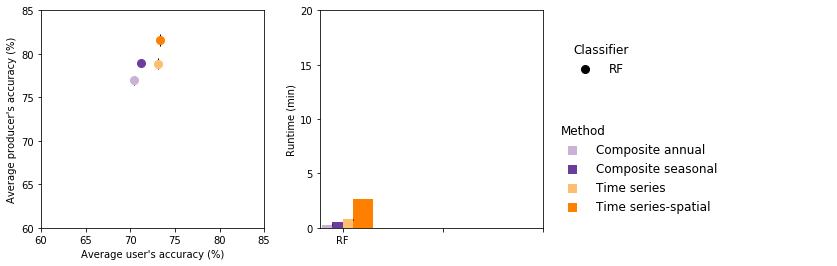

In [6]:
# plotting the classifier comparison

# chose 2 accuracy metrics
am_x = 'AvgUA'
am_y = 'AvgPa'


df = pd.read_csv(f'data/classification_data/classifier_comparison_as{yearAS}.csv')

grouped = df.groupby(['method','classifier'])
print(grouped.mean())
means = grouped.mean().to_dict()
stds = grouped.std().to_dict()


fig, axes = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
plt.subplots_adjust(wspace=0.25)
axes = axes.ravel()

ax = axes[0]
fontsize = 12
plt.rcParams.update({'font.size': fontsize})


classifiers = ['rf','svm','dnn']
classifiers = ['rf']
markers = ['o','^','*']
markers = ['o']

methods = ['ac','sc','t','ts']
inputs = ['Composite annual', 'Composite seasonal', 'Time series', 'Time series-spatial']
colors = ['#cab2d6','#6a3d9a','#fdbf6f','#ff7f00']

# classifiers (shape) for legend
cpoints = []
for i, clf in enumerate(classifiers):
    cpoint = ax.scatter(
        means[am_x][('ac',clf)],
        means[am_y][('ac',clf)],
        marker=markers[i],
        color='k',
        label=clf,
        s=1,
    )
    cpoints.append(cpoint)
    
# methods (color) for legend
mpoints = []
for i, method in enumerate(methods):
    mpoint = ax.scatter(
        means[am_x][(method,'rf')],
        means[am_y][(method,'rf')],
        marker='s',
        color=colors[i],
        label=inputs[i],
        s=1,
    )
    mpoints.append(mpoint)

# print accuracy data for classifiers and methods
for iclf, clf in enumerate(classifiers):
    for im, m in enumerate(methods):
        key = (m,clf)
        ax.errorbar(
            x=means[am_x][key],
            xerr=stds[am_x][key],
            y=means[am_y][key],
            yerr=stds[am_y][key],
            ms=8,
            c=colors[im],
            marker=markers[iclf],
            ecolor='k',
            elinewidth=1,
        )


lower, upper = (60, 85)
limits = [lower,upper]
ticks = np.arange(lower,upper+1,5)
labels = [f'{tick:.0f}' for tick in list(ticks)]

ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

ax.set_xlabel('Average user\'s accuracy (%)')
ax.set_ylabel('Average producer\'s accuracy (%)')

legend_xpos = 2.68

leg1 = ax.legend(
    cpoints,
    [clf.upper() for clf in classifiers],
    title='Classifier',
    bbox_to_anchor=(legend_xpos, 0.9),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg1._legend_box.align = "left"

leg2 = ax.legend(
    mpoints,
    inputs,
    title='Method',
    loc='center',
    bbox_to_anchor=(legend_xpos, 0.27),
    frameon=False,
    markerscale=8,
    handletextpad=1,
)
leg2._legend_box.align = "left"
ax.add_artist(leg1)



# change axis to right axis for runtime plot
ax = axes[1]


mean_runtime_data = []
std_runtime_data = []

for m in methods:
    runtime_mean_method = [means['runtime'].get((m,clf)) for clf in classifiers]
    mean_runtime_data.append(runtime_mean_method)
    runtime_std_method = [stds['runtime'].get((m,clf)) for clf in classifiers]
    std_runtime_data.append(runtime_std_method)


for i, (mean, std) in enumerate(zip(mean_runtime_data,std_runtime_data)):
    
    # rescaling to minutes
    mean = [m/60. for m in mean]
    std = [s/60. for s in std]
   
    
    wbar = 0.1
    xpos = [x-wbar+i*wbar for x in range(len(classifiers))]
     
    ax.bar(
        x=xpos,
        height=mean,
        yerr=std,
        width=0.2,
        color=colors[i],
        error_kw={'ecolor':'k','elinewidth':1},
    )
    

    
yticks = np.arange(0,21,5)
yticklabels = [f'{ytick:.0f}' for ytick in list(yticks)]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)


# ax.set_ylabel('Runtime (min)',rotation=270,labelpad=20)
ax.set_ylabel('Runtime (min)')
ax.set_xticks(range(3))
ax.set_xticklabels([clf.upper() for clf in classifiers])
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")

axes[2].axis('off')

plt.savefig('plots/classifier_comparison',dpi=300,bbox_inches='tight')
plt.show()

In [115]:
rois = ['roi1','roi2','roi3']

label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']

features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

subsample_sizes = [1,10,100,1000]
test_size = 0.3

# define classifiers
classifiers = {}
classifiers['rf'] = RandomForestClassifier(n_estimators=100,class_weight='balanced')
# classifiers['svm'] = svm.SVC(gamma='scale', decision_function_shape='ovo', class_weight='balanced')
# classifiers['dnn'] = DeepNeuralNetwork()


# data container
data = []
def add_data(data,base,users,producers):
    for i, (u,p) in enumerate(zip(users,producers)):
        data.append((i,*base,u,p))

# define number of iterations
n_iterations = 30

for i in range(n_iterations):
    print(f'Iteration: {i+1}/{n_iterations}')
    
    for s in subsample_sizes:
        
        
        # splitting data (using a different split and split ratio for each iteration)        
        train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)
        trainsubsample_coefs = [train_coefs[train_coefs['land_cover']==i].sample(n=s) for i in range(7)]
        trainsubsample_coefs = pd.concat(trainsubsample_coefs)
        
        
        for clf_key in classifiers.keys():
            print(f'{clf_key} {s}')
            clf  = classifiers[clf_key]
            
            # ts (time series-spatial)
            error_matrix_ts, run_time_ts, _ = train_validate_classifier(clf,trainsubsample_coefs,test_coefs,features_ts,label)
            users_ts = error_matrix_ts.users_accuracies()
            producers_ts = error_matrix_ts.producers_accuracies()
            add_data(data,(clf_key,'ts',s,run_time_ts),users_ts,producers_ts)
            
            
                        
d = {
    'land_cover': [entry[0] for entry in data],
    'classifier': [entry[1] for entry in data],
    'method': [entry[2] for entry in data],
    'ntraining': [entry[3] for entry in data],
    'runtime': [entry[4] for entry in data],
    'UA': [entry[5] for entry in data],
    'PA': [entry[6] for entry in data],
}
       
df = pd.DataFrame(data=d)
df.to_csv(f'{path}training_size_as{yearAS}.csv', encoding='utf-8', index=False)
df.head()


Iteration: 1/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 2/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 3/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 4/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 5/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 6/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 7/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 8/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 9/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 10/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 11/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 12/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 13/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 14/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 15/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 16/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 17/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 18/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 19/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 20/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 21/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 22/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 23/30
rf 1
rf 10
rf 100
rf 1000
Iteration: 24/30
rf 

,land_cover,classifier,method,ntraining,runtime,UA,PA
0,0,rf,ts,1,0.18584,3.758089,4.446408
1,1,rf,ts,1,0.18584,22.870491,42.024356
2,2,rf,ts,1,0.18584,51.650000,15.399523
3,3,rf,ts,1,0.18584,64.473530,67.751443
4,4,rf,ts,1,0.18584,44.719441,60.106653


[1, 10, 100, 1000]


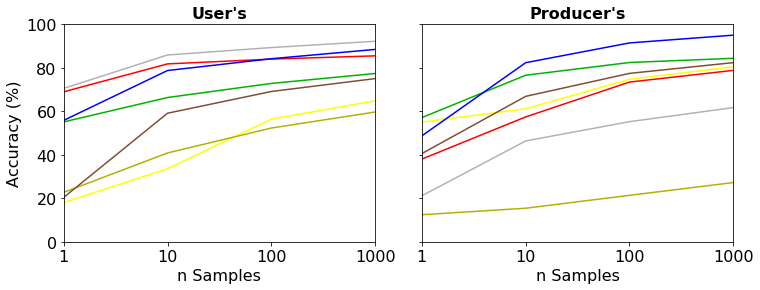

In [116]:
df = pd.read_csv(f'{path}training_size_as{yearAS}.csv')



metrics = ['UA','PA']
classifier = 'rf'
method = 'ts'
subsample_sizes = [1,10,100,1000]
print(subsample_sizes)

classes = ['Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']


fig, axes = plt.subplots(1,2,sharey=True)
fig.set_figheight(4)
fig.set_figwidth(12)
plt.subplots_adjust(wspace=0.15)
plt.xscale(value='log')
axes = axes.ravel()

fontsize = 16
plt.rcParams.update({'font.size': fontsize})

df = df[(df['method']==method) & (df['classifier']==classifier)]


    
for j, (class_,color) in enumerate(zip(classes,hex_colors)):
    df_class = df[df['land_cover']==j]
    means = df_class.groupby(['ntraining']).mean()
    y_uas = list(means['UA'])
    y_pas = list(means['PA'])
    
    axes[0].plot(subsample_sizes,y_uas,color=color,label=class_)
    axes[1].plot(subsample_sizes,y_pas,color=color,label=class_)
    

ymin, ymax = (0,100)
yticks = list(range(ymin,ymax+1,20))
xmin, xmax = (1,1000)

for ax in axes:
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_ylim([ymin,ymax])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks,fontdict={'fontsize': fontsize})
    
    ax.set_xlim([subsample_sizes[0],subsample_sizes[-1]])
    ax.set_xticks(subsample_sizes)
    ax.set_xticklabels(subsample_sizes,fontdict={'fontsize': fontsize})
    
    ax.set_xlabel('n Samples',fontsize=fontsize,fontweight='normal')
    
    



    
axes[0].set_ylabel('Accuracy (%)',fontsize=fontsize,fontweight='normal')
# axes[1].set_ylabel('Producer\'s accuracy (%)',fontsize=fontsize,fontweight='bold')
axes[1].set_xlabel('n Samples')

axes[0].set_title('User\'s',fontsize=fontsize,fontweight='bold')
axes[1].set_title('Producer\'s',fontsize=fontsize,fontweight='bold')

plt.savefig('plots/trainingsample_size',dpi=300,bbox_inches='tight')
plt.show()


Annual composite
[[3158  532   17  193  131   13    0]
 [ 359 7184  166 1143  488    3    1]
 [  56  828  338  658  124    3    0]
 [ 183 1009   85 6979   75   22    0]
 [ 108  713   58  281 4047   12   86]
 [  34   47    1   56   48 1124    5]
 [   0    0    0    0  168    1  513]]
Summary statistics (n Samples: 31050)

75.18 % (OA)
70.34 % (Average UA)
76.62 % (Average PA)
70.34 % (AA = Average UA)
72.76 % (MA = (OA + AA)/2)
0.68 (Kappa)

0: 78.09 % (UA) n Class: 4044; 81.02 % (PA) n Ref: 3898)
1: 76.88 % (UA) n Class: 9344; 69.66 % (PA) n Ref: 10313)
2: 16.84 % (UA) n Class: 2007; 50.83 % (PA) n Ref: 665)
3: 83.55 % (UA) n Class: 8353; 74.96 % (PA) n Ref: 9310)
4: 76.29 % (UA) n Class: 5305; 79.65 % (PA) n Ref: 5081)
5: 85.48 % (UA) n Class: 1315; 95.42 % (PA) n Ref: 1178)
6: 75.22 % (UA) n Class: 682; 84.79 % (PA) n Ref: 605)


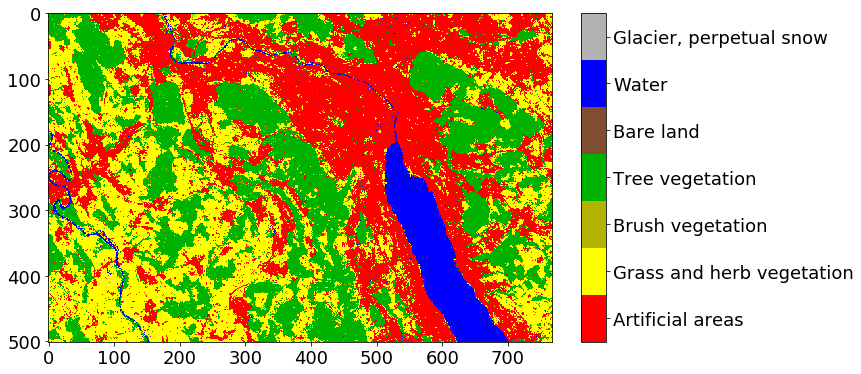

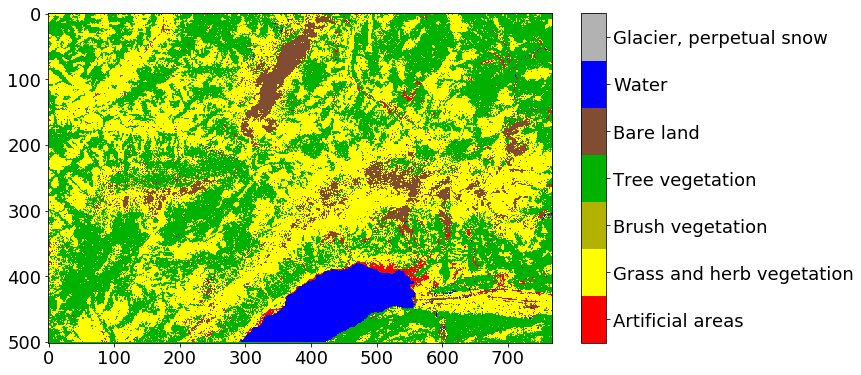

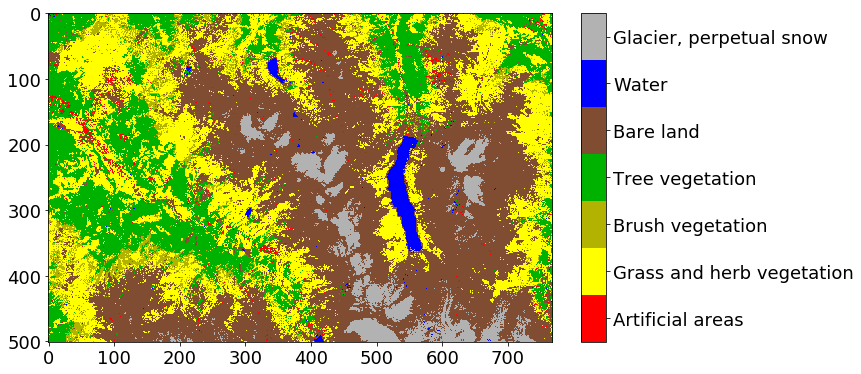

Seasonal composite
[[3060  553   15  167  103   16    0]
 [ 331 7330  114 1059  480    8    0]
 [  53  859  340  673  121    1    0]
 [ 179 1061   62 7013   80   11    0]
 [ 114  701   57  267 4223   14   61]
 [  30   46    0   47   44 1089    1]
 [   0    0    0    0  169    3  495]]
Summary statistics (n Samples: 31050)

75.85 % (OA)
70.77 % (Average UA)
78.53 % (Average PA)
70.77 % (AA = Average UA)
73.31 % (MA = (OA + AA)/2)
0.69 (Kappa)

0: 78.18 % (UA) n Class: 3914; 81.23 % (PA) n Ref: 3767)
1: 78.63 % (UA) n Class: 9322; 69.48 % (PA) n Ref: 10550)
2: 16.61 % (UA) n Class: 2047; 57.82 % (PA) n Ref: 588)
3: 83.43 % (UA) n Class: 8406; 76.01 % (PA) n Ref: 9226)
4: 77.67 % (UA) n Class: 5437; 80.90 % (PA) n Ref: 5220)
5: 86.63 % (UA) n Class: 1257; 95.36 % (PA) n Ref: 1142)
6: 74.21 % (UA) n Class: 667; 88.87 % (PA) n Ref: 557)


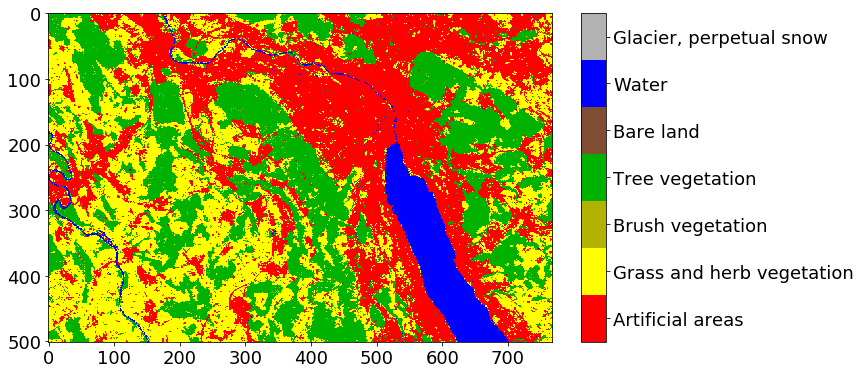

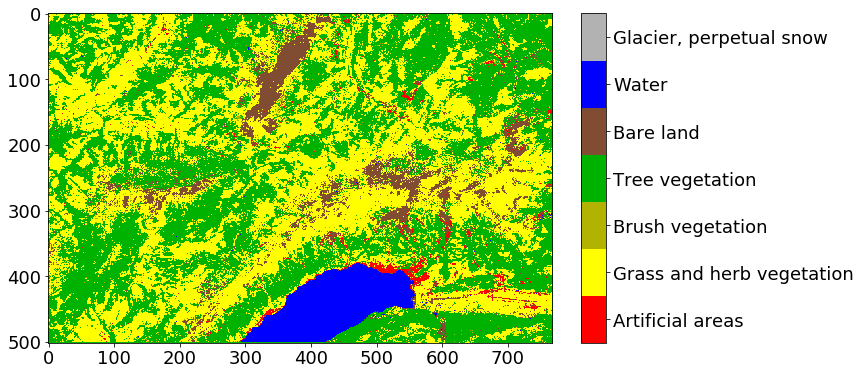

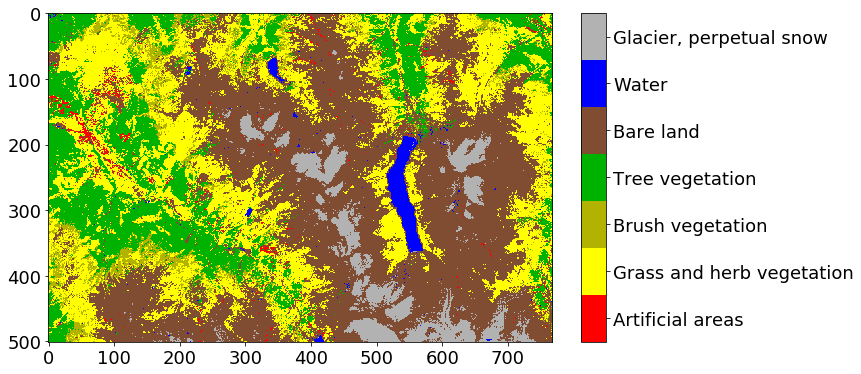

Time series
[[3304  521    5  153   30   11    0]
 [ 286 7560  153  868  437    2    0]
 [  38  771  461  547  161    1    0]
 [ 144  961  110 7056   64    7    0]
 [  74  519   72  161 4422    2  123]
 [  34   42    1   66   39 1165    1]
 [   3    0    0    0  174    0  501]]
Summary statistics (n Samples: 31050)

78.81 % (OA)
73.41 % (Average UA)
79.49 % (Average PA)
73.41 % (AA = Average UA)
76.11 % (MA = (OA + AA)/2)
0.73 (Kappa)

0: 82.11 % (UA) n Class: 4024; 85.09 % (PA) n Ref: 3883)
1: 81.24 % (UA) n Class: 9306; 72.87 % (PA) n Ref: 10374)
2: 23.29 % (UA) n Class: 1979; 57.48 % (PA) n Ref: 802)
3: 84.58 % (UA) n Class: 8342; 79.72 % (PA) n Ref: 8851)
4: 82.30 % (UA) n Class: 5373; 83.01 % (PA) n Ref: 5327)
5: 86.42 % (UA) n Class: 1348; 98.06 % (PA) n Ref: 1188)
6: 73.89 % (UA) n Class: 678; 80.16 % (PA) n Ref: 625)


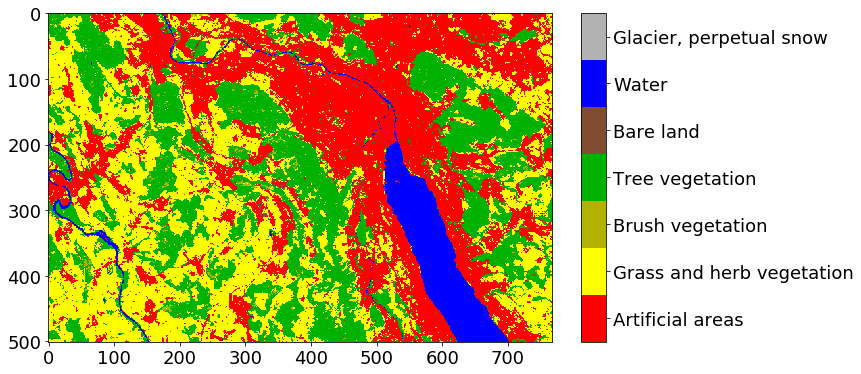

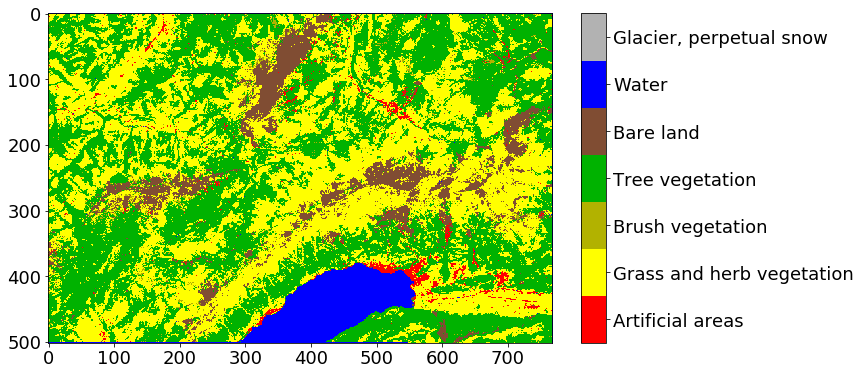

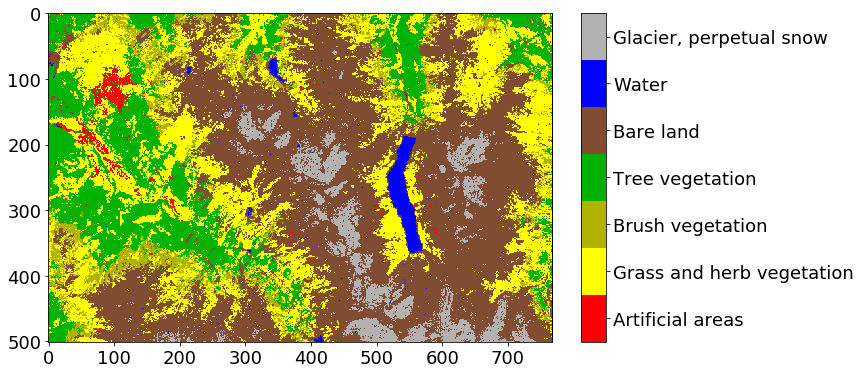

Time series-spatial
[[3291  555    3  131   33   11    0]
 [ 234 7829   87  727  427    2    0]
 [  28  874  376  551  149    1    0]
 [ 116  904   79 7187   52    4    0]
 [  54  612   39  147 4443    2   76]
 [  30   42    1   60   52 1160    3]
 [   0    0    0    0  166    0  512]]
Summary statistics (n Samples: 31050)

79.86 % (OA)
73.62 % (Average UA)
82.06 % (Average PA)
73.62 % (AA = Average UA)
76.74 % (MA = (OA + AA)/2)
0.74 (Kappa)

0: 81.78 % (UA) n Class: 4024; 87.69 % (PA) n Ref: 3753)
1: 84.13 % (UA) n Class: 9306; 72.38 % (PA) n Ref: 10816)
2: 19.00 % (UA) n Class: 1979; 64.27 % (PA) n Ref: 585)
3: 86.15 % (UA) n Class: 8342; 81.64 % (PA) n Ref: 8803)
4: 82.69 % (UA) n Class: 5373; 83.48 % (PA) n Ref: 5322)
5: 86.05 % (UA) n Class: 1348; 98.31 % (PA) n Ref: 1180)
6: 75.52 % (UA) n Class: 678; 86.63 % (PA) n Ref: 591)


In [87]:
# best working approach confusion matrix (class-wise) analysis and visual analysis

rois = ['roi1','roi2','roi3']


label = 'land_cover'

# define features
bands = ['blue','green','red','nir','swir1','swir2']
coefficients = ['c','a1','b1']
positions = ['topleft','topcenter','topright','midleft','midcenter','midright','lowerleft','lowercenter','lowerright']
seasons = ['spring','summer','autumn']

features_ac = bands
features_sc = [f'{band}_{season}' for band in bands for season in seasons]
features_t = [f'midcenter_{band}_{coef}' for band in bands for coef in coefficients]
features_ts = [f'{pos}_{band}_{coef}' for pos in positions for band in bands for coef in coefficients]

# split between training and testing data
test_size = 0.3

train_acomp, test_acomp = train_test_split(data_acomp, test_size=test_size)
train_scomp, test_scomp = train_test_split(data_scomp, test_size=test_size)
train_coefs, test_coefs = train_test_split(data_coefs, test_size=test_size)

# define filter used for gaussian filtering
gaussian_kernel3 = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

# define best working classifiers
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')


print('Annual composite')      
error_matrix_ac, _, trained_clf = train_validate_classifier(clf,train_acomp,test_acomp,features_ac,label)
error_matrix_ac.print_matrix()
error_matrix_ac.print_summary()

for roi in rois:
    fname = f'{path_comp}annual_composite_{roi}_{collection_year(roi,yearAS)}.tif'
    composite, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = composite.shape
    pixel_vector = composite.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    composite_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(composite_classified,geotransform,epsg,f'{path}rf_ac_{roi}_as{yearAS}')
    plot(composite_classified)

    
print('Seasonal composite')      
error_matrix_sc, _, trained_clf = train_validate_classifier(clf,train_scomp,test_scomp,features_sc,label)
error_matrix_sc.print_matrix()
error_matrix_sc.print_summary()

for roi in rois:
    
    fname_spring = f'{path_comp}seasonal_composite_spring_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_spring, geotransform, epsg = geotiff_to_datacube(fname_spring)
    
    fname_summer = f'{path_comp}seasonal_composite_summer_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_summer, geotransform, epsg = geotiff_to_datacube(fname_summer)
    
    fname_autumn = f'{path_comp}seasonal_composite_autumn_{roi}_{collection_year(roi,yearAS)}.tif'
    comp_autumn, geotransform, epsg = geotiff_to_datacube(fname_autumn)
    
    shape = comp_spring.shape
    composite = np.ndarray((shape[0],shape[1],len(bands)*len(seasons)))
    
    for i in range(len(bands)):
        composite[:,:,i*len(seasons)] = comp_spring[:,:,i]
        composite[:,:,i*len(seasons)+1] = comp_summer[:,:,i]
        composite[:,:,i*len(seasons)+2] = comp_autumn[:,:,i]
    
    
    # convert image to vector of pixels
    shape = composite.shape
    pixel_vector = composite.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    composite_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(composite_classified,geotransform,epsg,f'{path}rf_sc_{roi}_as{yearAS}')
    plot(composite_classified)






print('Time series')      
error_matrix_t, _, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_t,label)
error_matrix_t.print_matrix()
error_matrix_t.print_summary()

for roi in rois:
    fname = f'{path_coef}coefficients_{roi}_{collection_year(roi,yearAS)}.tif'
    coefficients, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = coefficients.shape
    pixel_vector = coefficients.reshape((shape[0]*shape[1], shape[2]))
    
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    coefficients_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(coefficients_classified,geotransform,epsg,f'{path}rf_t_{roi}_as{yearAS}')
    plot(coefficients_classified)
    


print('Time series-spatial')
error_matrix_ts, _, trained_clf = train_validate_classifier(clf,train_coefs,test_coefs,features_ts,label)
error_matrix_ts.print_matrix()
error_matrix_ts.print_summary()

for roi in rois:
    fname = f'data/coefficients/coefficients_{roi}_{collection_year(roi,yearAS)}.tif'
    coefficients, geotransform, epsg = geotiff_to_datacube(fname)
    # convert image to vector of pixels
    shape = coefficients.shape
    padded_coefficients = np.pad(coefficients, pad_width=((1,1),(1,1),(0,0)), mode='edge')
    
    pixel_vector = []    
    for irow in range(0,shape[0]):
        for icol in range(0,shape[1]):
            irowpad, icolpad = (irow+1,icol+1)
            kernel = padded_coefficients[irowpad-1:irowpad+2,icolpad-1:icolpad+2,:]
            pixel_vector.append(kernel.flatten())
        
    # classify pixel vector and reshape to image
    predictions = trained_clf.predict(pixel_vector)
    coefficients_classified = predictions.reshape((shape[0],shape[1]))
    
    save_geotiff(coefficients_classified,geotransform,epsg,f'{path}rf_ts_{roi}_as{yearAS}')
    # plot(coefficients_classified)

    
for roi in rois:
    classified_ts, geotransform, epsg = geotiff_to_datacube(f'{path}rf_ts_{roi}_as{yearAS}.tif')
    classified_ts_gf = gaussian_filter(classified_ts,3)
    
    save_geotiff(classified_ts_gf[:,:,0],geotransform,epsg,f'{path}rf_tsgf_{roi}_as{yearAS}')
    # plot(classified_ts_gf[:,:,0])
    
    
 

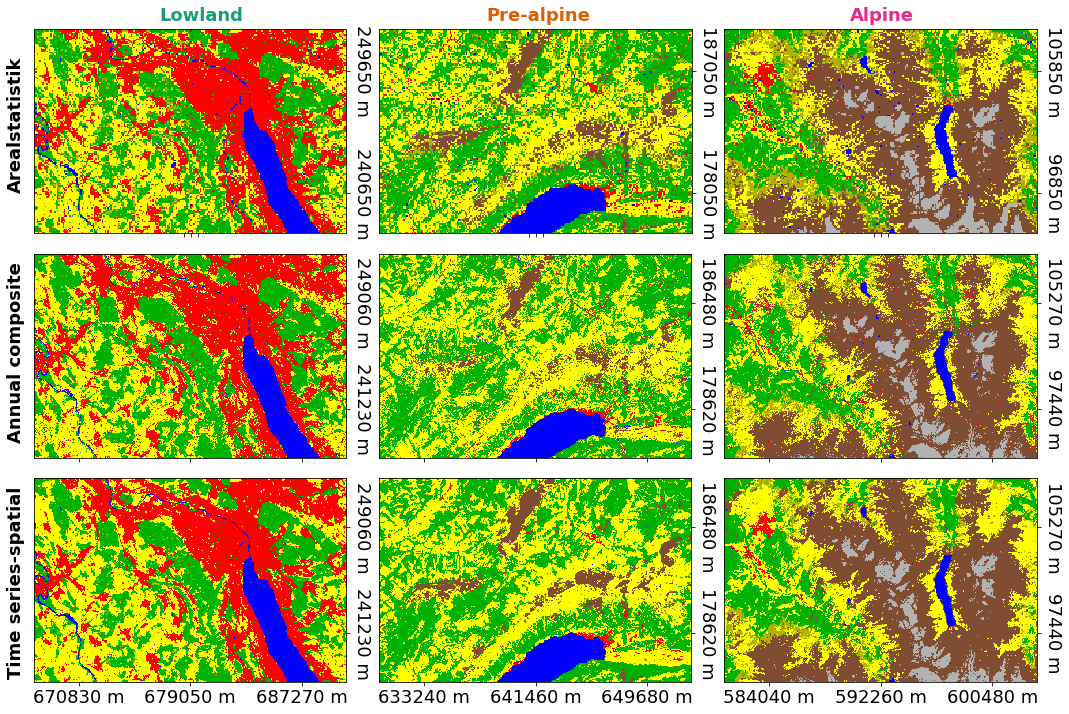

In [86]:
classes = ['Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']

classifier = 'rf'
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
methods = ['validation','ac','ts']
yearAS = 2004


def plot_classification(ax,fname,show_xlabels=True,show_ylabels=True):
    

    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
    
    classification, geotransform, epsg = geotiff_to_datacube(fname)
    shape = (classification.shape[0], classification.shape[1], 1)
    
    im = ax.imshow(classification[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,shape[1]//2,shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    
    # end of plot roi function
    

fontsize_title = 22
fontsize = 18


fig, axs = plt.subplots(3,3, figsize=(18,12), facecolor='w', edgecolor='k') # w h
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axs = axs.ravel()


for i, roi in enumerate(rois):
    for j, method in enumerate(methods):
        ax = axs[j*len(rois)+i]
        
        x_labels = True if j==len(methods)-1 else False
        y_labels = True
        
        if method == 'validation':
            fname = f'data/arealstatistik/validation_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,x_labels,y_labels)
        else:
            fname = f'data/classification_data/{classifier}_{method}_{roi}_as{yearAS}.tif'
            plot_classification(ax,fname,x_labels,y_labels)
    

    
fig.text(0.255, 0.89, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize,color='#1b9e77')
fig.text(0.515, 0.89, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize,color='#d95f02')
fig.text(0.78, 0.89, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize,color='#e7298a')

fig.text(0.105, 0.77, 'Arealstatistik', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)
fig.text(0.105, 0.506, 'Annual composite', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)
fig.text(0.105, 0.24, 'Time series-spatial', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize)

plt.savefig(f'plots/classification_visual_results.png', dpi=300, bbox_inches = "tight")
